
# Multi‑Task RNN (GRU) for Mental Health Dataset
This notebook:
- Loads the provided **Mental Health Dataset.csv**.
- Converts single-row survey responses into a **sequence**: each question becomes a time step and the answer is encoded at that step.
- Trains a **shared GRU encoder** with two heads:
  - **Classification**: `treatment` (Yes/No)
  - **Regression**: a **derived risk severity score** (continuous in [0, 1])
- Evaluates with standard metrics and saves artifacts.

> Note: The sequence here is an **engineering trick** (questions as steps) because the dataset is not a natural time series. If you later collect repeated surveys over time, you can swap in real temporal sequences easily.


In [8]:

# --- Setup ---
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, Model

DATA_PATH = "Mental.csv"  # <-- change if needed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [9]:

# --- Load ---
df = pd.read_csv(DATA_PATH)
print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (216421, 17)


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [10]:

# --- Basic cleaning & uniform casing ---
df = df.copy()

# Normalize column names (optional)
df.columns = [c.strip() for c in df.columns]

# Fill NaNs
df = df.fillna("Unknown")

# Quick peek at unique values per column:
for c in df.columns:
    nunique = df[c].nunique()
    print(f"{c}: {nunique} unique")


Timestamp: 580 unique
Gender: 2 unique
Country: 35 unique
Occupation: 5 unique
self_employed: 3 unique
family_history: 2 unique
treatment: 3 unique
Days_Indoors: 6 unique
Growing_Stress: 4 unique
Changes_Habits: 4 unique
Mental_Health_History: 4 unique
Mood_Swings: 4 unique
Coping_Struggles: 3 unique
Work_Interest: 4 unique
Social_Weakness: 4 unique
mental_health_interview: 4 unique
care_options: 4 unique



## Targets
- **Classification**: `treatment` → map Yes=1, No=0 (rows with other/unknown are dropped for the classifier).
- **Regression**: we derive a **severity score** from several signal-like answers:
    - `family_history` (Yes=1)
    - `Growing_Stress` (Yes=1)
    - `Changes_Habits` (Yes=1)
    - `Mental_Health_History` (Yes=1)
    - `Mood_Swings` (Low=0, Medium=0.5, High=1; others=0.5)
    - `Coping_Struggles` (Yes=1)
    - `Work_Interest` (No=1 indicates loss of interest)
    - `Social_Weakness` (Yes=1)
We average these signals to get a score in [0,1].


In [11]:

# --- Build targets ---

def yn_to01(x, one='Yes', zero='No'):
    x = str(x).strip().lower()
    if x == str(one).lower():
        return 1.0
    if x == str(zero).lower():
        return 0.0
    return np.nan

def mood_to_cont(x):
    x = str(x).strip().lower()
    if x in ["low"]:
        return 0.0
    if x in ["medium"]:
        return 0.5
    if x in ["high"]:
        return 1.0
    # default mid for unknown/other
    return 0.5

# Classification label
y_clf_raw = df["treatment"].map(lambda x: yn_to01(x, one="Yes", zero="No"))
# Some datasets may use variants; coerce non-numeric to NaN
y_clf = pd.to_numeric(y_clf_raw, errors="coerce")

# Regression label (derived severity)
signals = []
if "family_history" in df: signals.append(df["family_history"].map(lambda x: yn_to01(x, "Yes", "No")))
if "Growing_Stress" in df: signals.append(df["Growing_Stress"].map(lambda x: yn_to01(x, "Yes", "No")))
if "Changes_Habits" in df: signals.append(df["Changes_Habits"].map(lambda x: yn_to01(x, "Yes", "No")))
if "Mental_Health_History" in df: signals.append(df["Mental_Health_History"].map(lambda x: yn_to01(x, "Yes", "No")))
if "Mood_Swings" in df: signals.append(df["Mood_Swings"].map(mood_to_cont))
if "Coping_Struggles" in df: signals.append(df["Coping_Struggles"].map(lambda x: yn_to01(x, "Yes", "No")))
if "Work_Interest" in df:
    # Treat "No" as 1 (loss of interest), "Yes" as 0
    signals.append(df["Work_Interest"].map(lambda x: yn_to01(x, "No", "Yes")))
if "Social_Weakness" in df: signals.append(df["Social_Weakness"].map(lambda x: yn_to01(x, "Yes", "No")))

if len(signals) == 0:
    raise ValueError("No signals found to compute severity score. Please adjust the list above.")

signals_mat = np.vstack([pd.to_numeric(s, errors="coerce").fillna(0.5) for s in signals]).T
y_reg = np.nanmean(signals_mat, axis=1)  # average to [0,1]

print("y_clf nulls:", int(np.isnan(y_clf).sum()))
print("y_reg stats: min=%.3f max=%.3f mean=%.3f" % (np.nanmin(y_reg), np.nanmax(y_reg), np.nanmean(y_reg)))


y_clf nulls: 1
y_reg stats: min=0.062 max=0.938 mean=0.490



## Build Sequence Features
Each **question** becomes a **time step**. At each step, we encode the answer as a **one‑hot vector** sized to that question’s category count, then **pad** to a consistent feature size across steps.


In [12]:

# --- Select feature columns to include as steps ---
all_cols = df.columns.tolist()
# Drop obvious target/leakage/time columns
drop_cols = {"Timestamp", "treatment", "mental_health_interview"}  # remove targets & timestamps to avoid leakage
feature_steps = [c for c in all_cols if c not in drop_cols]

print("Sequence steps (questions):", feature_steps)
S = len(feature_steps)

# --- Fit category vocab per step & determine max categories ---
vocab_maps = {}
cat_sizes = []
for c in feature_steps:
    cats = sorted([str(v) for v in df[c].fillna("Unknown").unique()])
    # assign integer ids
    vocab_maps[c] = {cat: i for i, cat in enumerate(cats)}
    cat_sizes.append(len(cats))

max_cats = int(np.max(cat_sizes))
print("Max categories across steps:", max_cats)

# --- Encode into [N, S, F] ---
def to_sequence_tensor(df_in):
    N = df_in.shape[0]
    X = np.zeros((N, S, max_cats), dtype=np.float32)
    for si, c in enumerate(feature_steps):
        mapper = vocab_maps[c]
        idxs = df_in[c].fillna("Unknown").astype(str).map(mapper).fillna(0).astype(int).values
        # one-hot into padded slot
        for n in range(N):
            X[n, si, idxs[n]] = 1.0
    return X

X_all = to_sequence_tensor(df)
print("X_all shape:", X_all.shape)


Sequence steps (questions): ['Gender', 'Country', 'Occupation', 'self_employed', 'family_history', 'Days_Indoors', 'Growing_Stress', 'Changes_Habits', 'Mental_Health_History', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'Social_Weakness', 'care_options']
Max categories across steps: 35
X_all shape: (216421, 14, 35)


In [13]:

# --- Train/Val/Test split ---
valid_mask = ~np.isnan(y_clf)
X_valid = X_all[valid_mask]
y_clf_valid = y_clf[valid_mask].astype(float).values
y_reg_valid = y_reg[valid_mask].astype(float)

X_train, X_temp, yclf_train, yclf_temp, yreg_train, yreg_temp = train_test_split(
    X_valid, y_clf_valid, y_reg_valid, test_size=0.3, random_state=RANDOM_STATE, stratify=y_clf_valid
)
X_val, X_test, yclf_val, yclf_test, yreg_val, yreg_test = train_test_split(
    X_temp, yclf_temp, yreg_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=yclf_temp
)

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("Class balance (train): mean=%.3f" % yclf_train.mean())


Train: (151494, 14, 35)  Val: (32463, 14, 35)  Test: (32463, 14, 35)
Class balance (train): mean=0.519



## Model: Shared GRU + Two Heads
- **Input**: `[batch, steps, features]` where `steps=len(questions)` and `features=max(categories_per_question)` (padded one‑hot).
- **Encoder**: Bidirectional GRU(64) → global representation (we use the last state).
- **Heads**:
  - `risk_class` (sigmoid, binary cross-entropy)
  - `risk_score` (linear, MSE)


In [14]:

# --- Build the multi-task GRU model ---
tf.keras.backend.clear_session()

inp = layers.Input(shape=(S, max_cats), name="seq_input")
x = layers.Masking()(inp)  # (not strictly necessary; all steps present)
x = layers.Bidirectional(layers.GRU(64, return_sequences=False))(x)  # last state

# Classification head
h1 = layers.Dense(64, activation='relu')(x)
out_clf = layers.Dense(1, activation='sigmoid', name='risk_class')(h1)

# Regression head
h2 = layers.Dense(64, activation='relu')(x)
out_reg = layers.Dense(1, activation='linear', name='risk_score')(h2)

model = Model(inputs=inp, outputs=[out_clf, out_reg])
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'risk_class': 'binary_crossentropy', 'risk_score': 'mse'},
    loss_weights={'risk_class': 1.0, 'risk_score': 1.0},
    metrics={
  'risk_class': [tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')],
  'risk_score': [tf.keras.metrics.MeanAbsoluteError(name='mae'),
                 tf.keras.metrics.RootMeanSquaredError(name='rmse')]
}
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 14, 35)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 14, 35)    │          0 │ seq_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 14, 35)    │          0 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 14)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     38,784 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ risk_class (Dense)  │ (None, 1)         │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ risk_score (Dense)  │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,426 (216.51 KB)

 Trainable params: 55,426 (216.51 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# --- Train ---
EPOCHS = 20
BATCH_SIZE = 64

hist = model.fit(
    X_train,
    {'risk_class': yclf_train, 'risk_score': yreg_train},
    validation_data=(X_val, {'risk_class': yclf_val, 'risk_score': yreg_val}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 70s 27ms/step - loss: 0.5832 - risk_class_auc: 0.7647 - risk_class_loss: 0.5729 - risk_class_precision: 0.7078 - risk_class_recall: 0.7248 - risk_score_loss: 0.0104 - risk_score_mae: 0.0606 - risk_score_rmse: 0.0899 - val_loss: 0.5094 - val_risk_class_auc: 0.8223 - val_risk_class_loss: 0.5085 - val_risk_class_precision: 0.7419 - val_risk_class_recall: 0.7830 - val_risk_score_loss: 5.9153e-04 - val_risk_score_mae: 0.0190 - val_risk_score_rmse: 0.0243
Epoch 2/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - loss: 0.5045 - risk_class_auc: 0.8240 - risk_class_loss: 0.5040 - risk_class_precision: 0.7405 - risk_class_recall: 0.8039 - risk_score_loss: 5.2893e-04 - risk_score_mae: 0.0179 - risk_score_rmse: 0.0230 - val_loss: 0.4845 - val_risk_class_auc: 0.8410 - val_risk_class_loss: 0.4838 - val_risk_class_precision: 0.7602 - val_risk_class_recall: 0.7925 - val_risk_score_loss: 3.8081e-04 - val_risk_score_mae: 0.0152 - val_risk_score_rmse: 0.0195
Epoc

In [16]:
# --- Evaluate on test set ---
pred_clf_prob, pred_reg = model.predict(X_test, batch_size=256)

# Ensure 1D arrays
pred_clf_prob = np.asarray(pred_clf_prob).ravel()
pred_reg      = np.asarray(pred_reg).ravel()

auc = roc_auc_score(yclf_test, pred_clf_prob)
ap  = average_precision_score(yclf_test, pred_clf_prob)

y_pred_label = (pred_clf_prob >= 0.5).astype(int)
prec, rec, f1, _ = precision_recall_fscore_support(yclf_test, y_pred_label, average='binary')

mae  = mean_absolute_error(yreg_test, pred_reg)
mse  = mean_squared_error(yreg_test, pred_reg)
rmse = np.sqrt(mse)

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


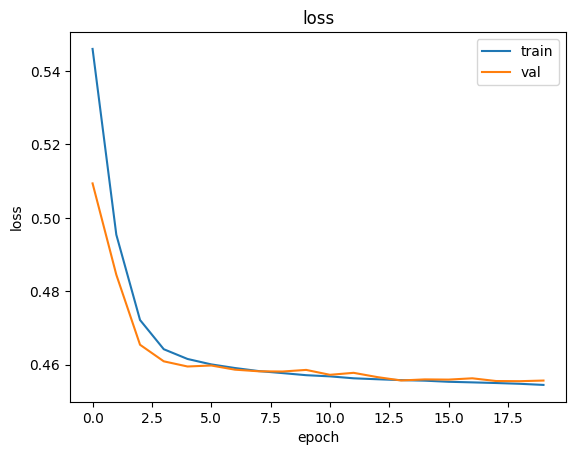

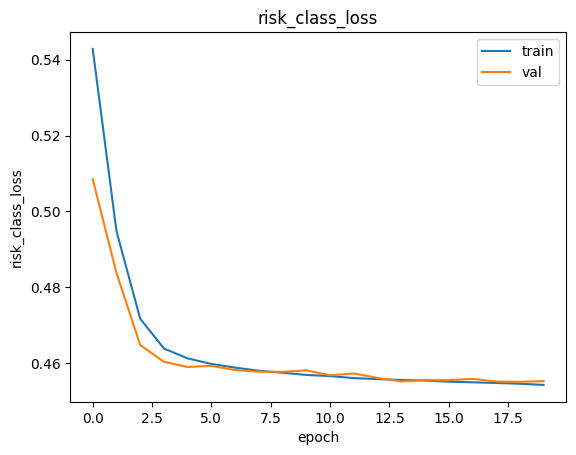

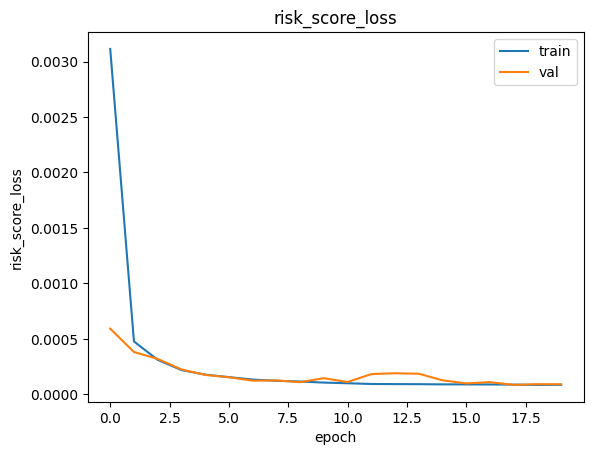

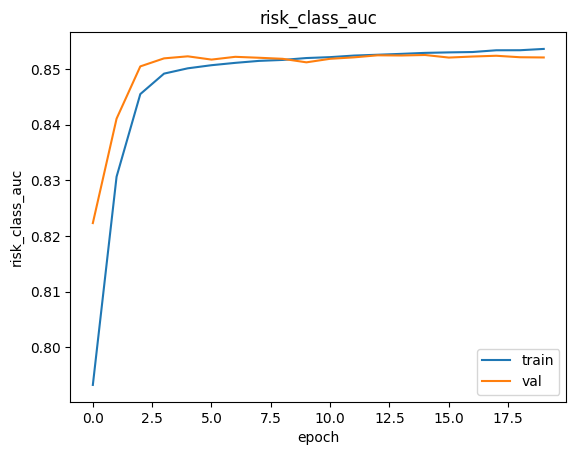

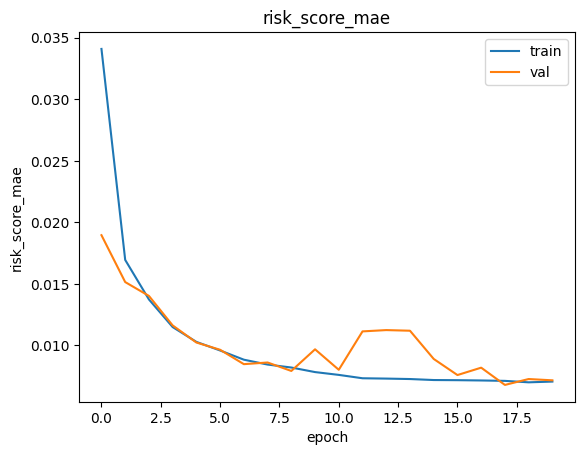

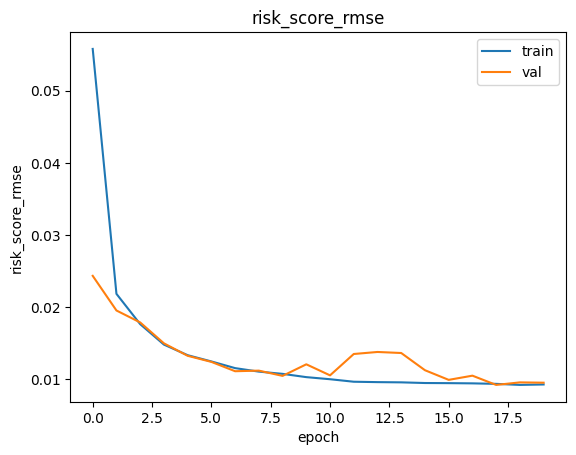

In [17]:

# --- Plot training curves ---
import matplotlib.pyplot as plt

def plot_metric(hist, key):
    plt.figure()
    plt.plot(hist.history[key], label='train')
    if 'val_' + key in hist.history:
        plt.plot(hist.history['val_' + key], label='val')
    plt.title(key)
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.legend()
    plt.show()

for k in ['loss', 'risk_class_loss', 'risk_score_loss', 'risk_class_auc', 'risk_score_mae', 'risk_score_rmse']:
    if k in hist.history:
        plot_metric(hist, k)


In [18]:

# --- Save model & encoders ---
ART_DIR = "/mnt/data/rnn_artifacts"
os.makedirs(ART_DIR, exist_ok=True)

model.save(os.path.join(ART_DIR, "multitask_gru.keras"))

# Save vocab maps and step order for reproducibility
import json
with open(os.path.join(ART_DIR, "feature_steps.json"), "w") as f:
    json.dump(feature_steps, f, indent=2)
with open(os.path.join(ART_DIR, "vocab_maps.json"), "w") as f:
    json.dump({k: v for k,v in vocab_maps.items()}, f, indent=2)

print("Saved artifacts to:", ART_DIR)


Saved artifacts to: /mnt/data/rnn_artifacts


In [19]:
import json
with open("/mnt/data/rnn_artifacts/feature_steps.json") as f:
    feature_steps = json.load(f)
print(feature_steps)


['Gender', 'Country', 'Occupation', 'self_employed', 'family_history', 'Days_Indoors', 'Growing_Stress', 'Changes_Habits', 'Mental_Health_History', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'Social_Weakness', 'care_options']


1.

In [20]:
# --- Integrated Gradients utilities (no extra installs needed) ---
import numpy as np
import tensorflow as tf
from typing import Tuple

def interpolate_inputs(baseline: np.ndarray, inputs: np.ndarray, alphas: np.ndarray) -> np.ndarray:
    # shape: (m, N, S, F)
    alphas_x = alphas.reshape((-1, 1, 1, 1))
    return baseline[None, ...] + alphas_x * (inputs[None, ...] - baseline[None, ...])

@tf.function
def _batch_gradients(model, x_batch, head_index: int):
    """Return gradients of the chosen head wrt inputs.
       head_index: 0 -> classification head, 1 -> regression head."""
    with tf.GradientTape() as tape:
        tape.watch(x_batch)
        outputs = model(x_batch, training=False)
        y = outputs[head_index]
        # For binary classification, use the logit for better gradients:
        if head_index == 0:
            # y is sigmoid; convert to logit: log(p/(1-p)) = log(p+eps) - log(1-p+eps)
            eps = tf.constant(1e-7, dtype=y.dtype)
            y = tf.math.log(tf.clip_by_value(y, eps, 1.0 - eps)) - tf.math.log(1.0 - tf.clip_by_value(y, eps, 1.0 - eps))
        # Reduce over output dims to a scalar per example
        y = tf.reduce_sum(y)  # sum over batch gives scalar for tape.gradient
    grads = tape.gradient(y, x_batch)
    return grads

def integrated_gradients(model, inputs: np.ndarray, head_index: int, baseline: np.ndarray = None, m_steps: int = 64, batch_size: int = 128) -> np.ndarray:
    """Compute IG attributions for a batch of inputs.
    Returns attributions with same shape as inputs: (N, S, F).
    """
    inputs = np.asarray(inputs).astype(np.float32)
    N, S, F = inputs.shape
    if baseline is None:
        baseline = np.zeros_like(inputs)
    else:
        baseline = np.asarray(baseline).astype(np.float32)
        if baseline.shape != inputs.shape:
            # if a single baseline is provided as (S, F), broadcast it
            if baseline.shape == (S, F):
                baseline = np.repeat(baseline[None, ...], N, axis=0)
            else:
                raise ValueError("baseline must have shape (N,S,F) or (S,F)")

    # Alphas on [0,1]
    alphas = np.linspace(0.0, 1.0, num=m_steps, dtype=np.float32)

    # Riemann sum of gradients along the path
    total_gradients = np.zeros_like(inputs, dtype=np.float32)

    # We’ll iterate alphas in mini-batches for memory efficiency
    alpha_bs = max(1, min(m_steps, 16))
    for start in range(0, m_steps, alpha_bs):
        end = min(m_steps, start + alpha_bs)
        alpha_slice = alphas[start:end]  # (a,)
        # Tile inputs for the alpha slice
        x_interp = interpolate_inputs(baseline, inputs, alpha_slice)  # (a,N,S,F)
        aN = x_interp.shape[0] * x_interp.shape[1]
        x_interp = x_interp.reshape((aN, S, F))

        # Run in batches
        grads_accum = np.zeros_like(x_interp, dtype=np.float32)
        for b in range(0, aN, batch_size):
            xb = x_interp[b:b+batch_size]
            gb = _batch_gradients(model, tf.convert_to_tensor(xb), head_index).numpy()
            grads_accum[b:b+batch_size] = gb

        grads_accum = grads_accum.reshape((alpha_slice.shape[0], N, S, F))
        total_gradients += np.mean(grads_accum, axis=0)  # average over alphas-batch

    # Average over all alphas and multiply by (inputs - baseline)
    avg_grads = total_gradients / m_steps
    attributions = (inputs - baseline) * avg_grads
    return attributions  # (N,S,F)

In [21]:
# --- Compute IG on a subset and aggregate per question ---
import numpy as np
import pandas as pd

# Choose a subset from test set for speed (adjust as you like)
N_SAMPLE = min(512, X_test.shape[0])
X_sub = X_test[:N_SAMPLE]

# Baseline: all-zeros (i.e., "no answer" vector) works fine for one-hot
baseline = np.zeros((X_sub.shape[1], X_sub.shape[2]), dtype=np.float32)  # (S,F)

# Compute IG for both heads
ig_clf = integrated_gradients(model, X_sub, head_index=0, baseline=baseline, m_steps=64, batch_size=128)  # (N,S,F)
ig_reg = integrated_gradients(model, X_sub, head_index=1, baseline=baseline, m_steps=64, batch_size=128)

# Reduce to the attribution of the chosen category at each step:
# For each sample n and step s, find the index j where X_sub[n,s,j] == 1 and take attribution there.
def chosen_cat_attribs(ig: np.ndarray, X: np.ndarray) -> np.ndarray:
    # elementwise product sums to the attribution of the active one-hot index
    return np.sum(ig * X, axis=2)  # shape (N,S)

attr_clf_per_step = chosen_cat_attribs(ig_clf, X_sub)  # (N,S)
attr_reg_per_step = chosen_cat_attribs(ig_reg, X_sub)  # (N,S)

# Aggregate across samples: mean attribution per question/step
mean_attr_clf = attr_clf_per_step.mean(axis=0)  # (S,)
mean_attr_reg = attr_reg_per_step.mean(axis=0)  # (S,)

# Build summary tables
df_attr_clf = pd.DataFrame({
    "question": feature_steps,
    "mean_attr": mean_attr_clf
}).sort_values("mean_attr", ascending=False).reset_index(drop=True)

df_attr_reg = pd.DataFrame({
    "question": feature_steps,
    "mean_attr": mean_attr_reg
}).sort_values("mean_attr", ascending=False).reset_index(drop=True)

# Top 10 positive & negative for each head
top_pos_clf = df_attr_clf.head(10).copy()
top_neg_clf = df_attr_clf.tail(10).iloc[::-1].copy()

top_pos_reg = df_attr_reg.head(10).copy()
top_neg_reg = df_attr_reg.tail(10).iloc[::-1].copy()

print("Top positive (Classification):"); display(top_pos_clf)
print("Top negative (Classification):"); display(top_neg_clf)
print("Top positive (Regression):");     display(top_pos_reg)
print("Top negative (Regression):");     display(top_neg_reg)

Top positive (Classification):


,question,mean_attr
0,care_options,0.005813
1,family_history,0.002362
2,Social_Weakness,0.001781
3,Occupation,0.000763
4,Work_Interest,0.000336
5,Changes_Habits,0.000042
6,Days_Indoors,0.000038
7,Coping_Struggles,-0.000274
8,Mental_Health_History,-0.000304
9,Growing_Stress,-0.000492


Top negative (Classification):


,question,mean_attr
13,Country,-0.015665
12,self_employed,-0.013760
11,Gender,-0.009704
10,Mood_Swings,-0.000786
9,Growing_Stress,-0.000492
8,Mental_Health_History,-0.000304
7,Coping_Struggles,-0.000274
6,Days_Indoors,0.000038
5,Changes_Habits,0.000042
4,Work_Interest,0.000336


Top positive (Regression):


,question,mean_attr
0,Coping_Struggles,0.004578
1,care_options,0.003295
2,Country,0.003169
3,Social_Weakness,0.001379
4,family_history,0.000895
5,Gender,0.000865
6,Growing_Stress,0.000312
7,self_employed,0.000286
8,Occupation,0.000180
9,Changes_Habits,0.000048


Top negative (Regression):


,question,mean_attr
13,Mood_Swings,-0.001575
12,Work_Interest,-0.001351
11,Mental_Health_History,-0.000305
10,Days_Indoors,0.000048
9,Changes_Habits,0.000048
8,Occupation,0.000180
7,self_employed,0.000286
6,Growing_Stress,0.000312
5,Gender,0.000865
4,family_history,0.000895


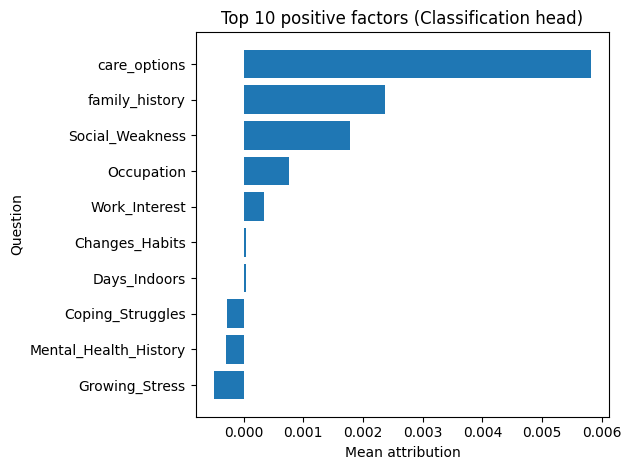

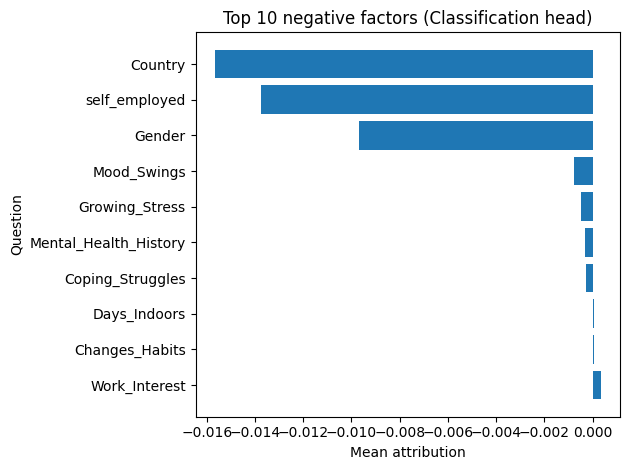

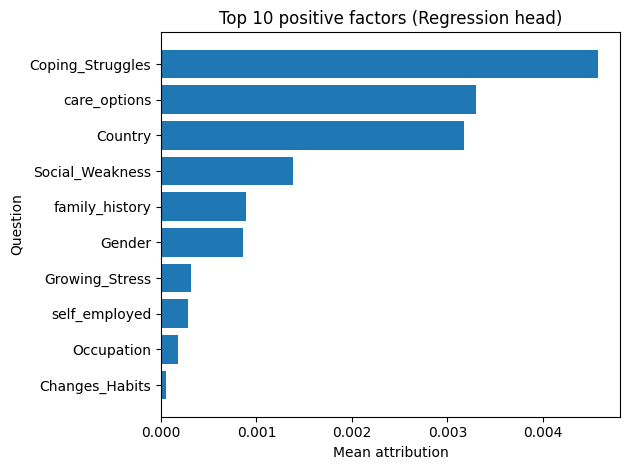

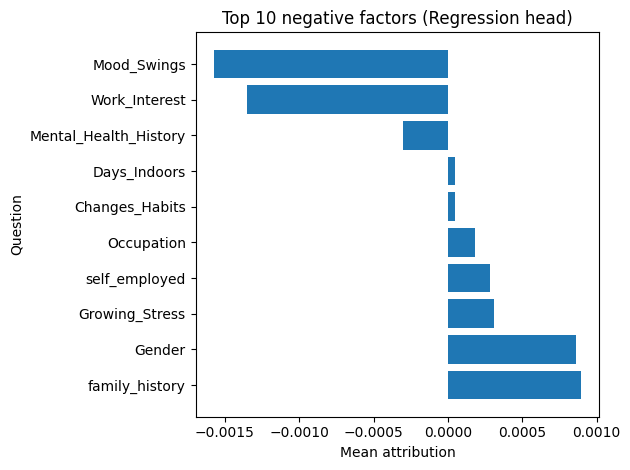

In [22]:
# --- Bar charts for the report ---
import matplotlib.pyplot as plt

def barplot(df, title):
    plt.figure()
    plt.barh(df["question"][::-1], df["mean_attr"][::-1])
    plt.title(title)
    plt.xlabel("Mean attribution")
    plt.ylabel("Question")
    plt.tight_layout()
    plt.show()

barplot(top_pos_clf, "Top 10 positive factors (Classification head)")
barplot(top_neg_clf, "Top 10 negative factors (Classification head)")
barplot(top_pos_reg, "Top 10 positive factors (Regression head)")
barplot(top_neg_reg, "Top 10 negative factors (Regression head)")

In [23]:
# --- Correlate per-question categories with predicted probabilities (sanity check) ---
# Get predicted probabilities on the same subset
proba_sub, reg_sub = model.predict(X_sub, batch_size=256)
proba_sub = proba_sub.ravel()
reg_sub   = reg_sub.ravel()

# For each question (step), compute the average proba/score per category
per_question_effects = []
for s, q in enumerate(feature_steps):
    # category id -> mask -> mean proba/score
    # recover vocab size by looking for any non-zero across F
    # (we know max_cats is padded beyond actual vocab size)
    # we'll infer active category per sample
    cat_ids = np.argmax(X_sub[:, s, :], axis=1)  # (N_SAMPLE,)
    for j in np.unique(cat_ids):
        mask = (cat_ids == j)
        per_question_effects.append({
            "question": q,
            "category_id": int(j),
            "mean_proba": float(proba_sub[mask].mean()) if mask.any() else np.nan,
            "mean_severity": float(reg_sub[mask].mean()) if mask.any() else np.nan,
            "support": int(mask.sum())
        })

effects_df = pd.DataFrame(per_question_effects).sort_values(["question", "support"], ascending=[True, False])
effects_df.head(20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


,question,category_id,mean_proba,mean_severity,support
43,Changes_Habits,0,5.356622e-01,0.496253,181
45,Changes_Habits,3,4.865512e-01,0.540348,167
44,Changes_Habits,1,5.214068e-01,0.434131,164
53,Coping_Struggles,2,5.078763e-01,0.543459,262
52,Coping_Struggles,0,5.226241e-01,0.435484,250
24,Country,34,5.580641e-01,0.499003,296
23,Country,33,4.879188e-01,0.457121,85
5,Country,4,6.410769e-01,0.486983,41
2,Country,0,6.438339e-01,0.534255,15
12,Country,16,2.862614e-01,0.573302,13


In [30]:
import shap, numpy as np, pandas as pd

# Shapes
S = X_train.shape[1]
F = X_train.shape[2]

# 1) Wrap model to accept FLAT input, reshape back to (S,F), and return ONLY the classification head
def f_class_flat(x_flat):
    x = x_flat.reshape((-1, S, F)).astype(np.float32)
    return model(x, training=False)[0].numpy()   # (batch, 1)

# 2) Background & masker in FLAT space
background = X_train[:200]
background_flat = background.reshape(background.shape[0], -1)
masker = shap.maskers.Independent(background_flat)

# 3) Build explainer
explainer = shap.Explainer(f_class_flat, masker)

# 4) Explain a test slice (FLAT), then reshape SHAP values back to (S,F)
X_slice = X_test[:200]
X_slice_flat = X_slice.reshape(X_slice.shape[0], -1)
shap_exp = explainer(X_slice_flat)
vals_flat = shap_exp.values         # shape: (N, S*F)
shap_vals = vals_flat.reshape(X_slice.shape[0], S, F)  # (N,S,F)

# 5) Aggregate over the one-hot category dimension to get per-question importance
mean_abs = np.mean(np.abs(shap_vals), axis=(0, 2))   # (S,)
mean_signed = np.mean(shap_vals, axis=(0, 2))        # (S,)

fi = pd.DataFrame({
    "Feature": feature_steps,
    "Importance": mean_abs,
    "Signed": mean_signed
}).sort_values("Importance", ascending=False)

# Top 10 overall, top positive/negative (directional)
top10 = fi.head(10)
top_pos = fi.sort_values("Signed", ascending=False).head(10)[["Feature","Signed"]]
top_neg = fi.sort_values("Signed", ascending=True).head(10)[["Feature","Signed"]]

print("Top 10 overall drivers (|SHAP|):"); display(top10)
print("\nTop positive contributors (raise risk):"); display(top_pos)
print("\nTop negative contributors (lower risk):"); display(top_neg)

# Save for the report
fi.to_csv("/mnt/data/shap_feature_importance_per_question.csv", index=False)
top_pos.to_csv("/mnt/data/shap_top_positive.csv", index=False)
top_neg.to_csv("/mnt/data/shap_top_negative.csv", index=False)

PermutationExplainer explainer: 201it [09:21,  2.82s/it]

Top 10 overall drivers (|SHAP|):


,Feature,Importance,Signed
13,care_options,0.004572,-0.000135
1,Country,0.004286,0.000034
4,family_history,0.003779,-0.001228
2,Occupation,0.003024,-0.000176
0,Gender,0.001463,-0.000120
5,Days_Indoors,0.000993,-0.000119
3,self_employed,0.000874,-0.000112
12,Social_Weakness,0.000586,0.000027
6,Growing_Stress,0.000399,0.000016
7,Changes_Habits,0.000246,-0.000018



Top positive contributors (raise risk):


,Feature,Signed
1,Country,0.000034
12,Social_Weakness,0.000027
6,Growing_Stress,0.000016
10,Coping_Struggles,0.000014
9,Mood_Swings,0.000007
11,Work_Interest,-0.000002
8,Mental_Health_History,-0.000014
7,Changes_Habits,-0.000018
3,self_employed,-0.000112
5,Days_Indoors,-0.000119



Top negative contributors (lower risk):


,Feature,Signed
4,family_history,-0.001228
2,Occupation,-0.000176
13,care_options,-0.000135
0,Gender,-0.000120
5,Days_Indoors,-0.000119
3,self_employed,-0.000112
7,Changes_Habits,-0.000018
8,Mental_Health_History,-0.000014
11,Work_Interest,-0.000002
9,Mood_Swings,0.000007


In [33]:
import numpy as np
import pandas as pd

# -----------------------------
# Config
# -----------------------------
FEATURES_OF_INTEREST = ["Country", "Social_Weakness", "Growing_Stress",
                        "family_history", "Occupation", "care_options"]
N_SAMPLE = min(2000, X_test.shape[0])   # slice for speed/memory
EXCLUDE_UNKNOWN = True                  # hide "Unknown" in outputs

# -----------------------------
# 1) Get attribution tensor (N,S,F) for CLASSIFICATION head
# -----------------------------
def have(name, g=globals()):
    return (name in g) and (g[name] is not None)

attr = None
source = None

if have("shap_vals"):
    # Expect shap_vals with shape (N,S,F)
    attr = shap_vals
    source = "SHAP"
elif have("ig_clf"):
    # Expect ig_clf with shape (N,S,F)
    attr = ig_clf
    source = "Integrated Gradients (cached)"
else:
    # Compute Integrated Gradients quickly if not present
    # Uses the helper integrated_gradients() you likely added earlier.
    # If it's not present, this will raise a NameError and remind you to paste the IG helper cell.
    baseline = np.zeros((X_test.shape[1], X_test.shape[2]), dtype=np.float32)  # (S,F)
    attr = integrated_gradients(model, X_test[:N_SAMPLE], head_index=0, baseline=baseline,
                                m_steps=64, batch_size=128)
    source = "Integrated Gradients (computed now)"

print(f"[info] Using attribution source: {source}")
# If attr was built on a slice, ensure we slice X_test to match
if attr.shape[0] != X_test.shape[0]:
    X_eval = X_test[:attr.shape[0]]
else:
    X_eval = X_test

# -----------------------------
# 2) Build inverse vocab maps: id -> category string per step
# -----------------------------
inv_vocab = {}
for q in feature_steps:
    m = vocab_maps[q]
    inv_vocab[q] = {idx: cat for cat, idx in m.items()}

# -----------------------------
# 3) For each feature (step), compute category-wise contribution
#    We average the attribution of the chosen one-hot category,
#    but ONLY over rows where that category is active.
# -----------------------------
def per_feature_category_stats(step_name, attr_tensor, X_tensor):
    """
    Returns a DataFrame with columns:
    ['category_id','category','support','mean_signed','mean_abs']
    for the given feature step.
    """
    s = feature_steps.index(step_name)
    # find chosen category per row for this step
    cat_ids = np.argmax(X_tensor[:, s, :], axis=1)  # (N,)
    # attribution value at the chosen category = sum over j of (attr * X) = just the active index
    chosen_attr = (attr_tensor[:, s, :] * X_tensor[:, s, :]).sum(axis=1)  # (N,)

    rows = []
    for j in np.unique(cat_ids):
        mask = (cat_ids == j)
        if not np.any(mask):
            continue
        mean_signed = float(chosen_attr[mask].mean())
        mean_abs = float(np.abs(chosen_attr[mask]).mean())
        cat = inv_vocab[step_name].get(int(j), f"cat_{int(j)}")
        rows.append({
            "category_id": int(j),
            "category": cat,
            "support": int(mask.sum()),
            "mean_signed": mean_signed,  # >0 raises risk, <0 lowers risk (on average)
            "mean_abs": mean_abs         # magnitude of effect (importance for this category)
        })
    df = pd.DataFrame(rows).sort_values("mean_signed", ascending=False).reset_index(drop=True)
    if EXCLUDE_UNKNOWN:
        df = df[df["category"].astype(str).str.lower() != "unknown"]
    return df

# -----------------------------
# 4) Summarize for your features: top↑ and top↓ values
# -----------------------------
summary = {}
for feat in FEATURES_OF_INTEREST:
    df_feat = per_feature_category_stats(feat, attr, X_eval)

    top_pos = df_feat.sort_values(["mean_signed","support"], ascending=[False, False]).head(5)[
        ["category","mean_signed","support","mean_abs"]
    ]
    top_neg = df_feat.sort_values(["mean_signed","support"], ascending=[True, False]).head(5)[
        ["category","mean_signed","support","mean_abs"]
    ]

    summary[feat] = {"top_positive_values": top_pos, "top_negative_values": top_neg}

# -----------------------------
# 5) Display nicely
# -----------------------------
for feat, parts in summary.items():
    print(f"\n=== {feat} ===")
    print("High-risk values (push predictions up):")
    display(parts["top_positive_values"])
    print("Low-risk values (push predictions down):")
    display(parts["top_negative_values"])

# Optional: save each table to CSVs
for feat, parts in summary.items():
    parts["top_positive_values"].to_csv(f"/mnt/data/{feat}_high_risk_values.csv", index=False)
    parts["top_negative_values"].to_csv(f"/mnt/data/{feat}_low_risk_values.csv", index=False)

print("\nSaved CSVs for each feature in /mnt/data/")

[info] Using attribution source: SHAP

=== Country ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,New Zealand,0.266602,2,0.266602
1,Denmark,0.224707,1,0.224707
2,Netherlands,0.140226,2,0.140226
3,South Africa,0.122367,1,0.122367
4,United Kingdom,0.095548,32,0.103417


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
16,France,-0.544051,3,0.544051
15,Singapore,-0.335313,1,0.335313
14,Italy,-0.260097,1,0.260097
13,Brazil,-0.105227,2,0.105227
12,Switzerland,-0.075698,1,0.075698



=== Social_Weakness ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,Yes,0.015993,61,0.016532
1,Maybe,-0.005810,74,0.008345
2,No,-0.007052,65,0.008766


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
2,No,-0.007052,65,0.008766
1,Maybe,-0.005810,74,0.008345
0,Yes,0.015993,61,0.016532



=== Growing_Stress ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,No,0.008843,61,0.010341
1,Yes,-0.000231,75,0.003310
2,Maybe,-0.007873,64,0.009169


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
2,Maybe,-0.007873,64,0.009169
1,Yes,-0.000231,75,0.003310
0,No,0.008843,61,0.010341



=== family_history ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,Yes,0.061366,72,0.061366
1,No,-0.069329,128,0.069409


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
1,No,-0.069329,128,0.069409
0,Yes,0.061366,72,0.061366



=== Occupation ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,Business,-0.024821,33,0.055778
1,Housewife,-0.034747,44,0.046223
2,Student,-0.036545,33,0.054814
3,Others,-0.051343,54,0.071351
4,Corporate,-0.065904,36,0.077019


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
4,Corporate,-0.065904,36,0.077019
3,Others,-0.051343,54,0.071351
2,Student,-0.036545,33,0.054814
1,Housewife,-0.034747,44,0.046223
0,Business,-0.024821,33,0.055778



=== care_options ===
High-risk values (push predictions up):


,category,mean_signed,support,mean_abs
0,Yes,0.137433,65,0.138580
1,No,-0.032623,71,0.042432
2,Not sure,-0.068368,64,0.074081


Low-risk values (push predictions down):


,category,mean_signed,support,mean_abs
2,Not sure,-0.068368,64,0.074081
1,No,-0.032623,71,0.042432
0,Yes,0.137433,65,0.138580



Saved CSVs for each feature in /mnt/data/


2.

In [34]:
# --- Predict with the classification head + choose thresholds on VAL ---
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, f1_score

# Helper to flatten (N,1) -> (N,)
def ravel1(x):
    x = np.asarray(x)
    return x.ravel() if x.ndim > 1 else x

# 1) Get probabilities from classification head (index 0)
val_proba, _ = model.predict(X_val, batch_size=256)
val_proba = ravel1(val_proba)

test_proba, _ = model.predict(X_test, batch_size=256)
test_proba = ravel1(test_proba)

# 2) Find F1-optimal threshold on the validation set
prec, rec, thr = precision_recall_curve(yclf_val, val_proba)
f1 = (2*prec*rec) / (prec+rec + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5

# 3) (Optional) a high-recall threshold target, e.g., >= 0.85 recall
target_recall = 0.85
# pick the smallest threshold achieving >= target_recall
cand = np.where(rec >= target_recall)[0]
thr_recall = float(thr[cand[0]]) if len(cand) and cand[0] < len(thr) else best_thr

print(f"VAL AUC = {roc_auc_score(yclf_val, val_proba):.3f} | PR-AUC = {average_precision_score(yclf_val, val_proba):.3f}")
print(f"Best F1 threshold on VAL = {best_thr:.4f}  (F1={f1[best_idx]:.3f}, P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f})")
print(f"High-recall threshold (≈{target_recall:.2f} recall) on VAL = {thr_recall:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
VAL AUC = 0.852 | PR-AUC = 0.868
Best F1 threshold on VAL = 0.4022  (F1=0.796, P=0.749, R=0.850)
High-recall threshold (≈0.85 recall) on VAL = 0.0000


In [35]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_at_threshold(y_true, proba, thr):
    yhat = (proba >= thr).astype(int)
    auc  = roc_auc_score(y_true, proba)
    ap   = average_precision_score(y_true, proba)
    print(f"\n=== Threshold = {thr:.4f} ===")
    print(f"AUC={auc:.3f} | PR-AUC={ap:.3f}")
    print(classification_report(y_true, yhat, digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_true, yhat))
    return yhat

print("\n--- TEST set (F1-optimal threshold) ---")
yhat_best = evaluate_at_threshold(yclf_test, test_proba, best_thr)

print("\n--- TEST set (High-recall threshold) ---")
yhat_recall = evaluate_at_threshold(yclf_test, test_proba, thr_recall)


--- TEST set (F1-optimal threshold) ---

=== Threshold = 0.4022 ===
AUC=0.847 | PR-AUC=0.863
              precision    recall  f1-score   support

         0.0      0.803     0.694     0.744     15603
         1.0      0.748     0.842     0.793     16860

    accuracy                          0.771     32463
   macro avg      0.776     0.768     0.768     32463
weighted avg      0.775     0.771     0.769     32463

Confusion matrix:
 [[10825  4778]
 [ 2658 14202]]

--- TEST set (High-recall threshold) ---

=== Threshold = 0.0000 ===
AUC=0.847 | PR-AUC=0.863
              precision    recall  f1-score   support

         0.0      1.000     0.000     0.000     15603
         1.0      0.519     1.000     0.684     16860

    accuracy                          0.519     32463
   macro avg      0.760     0.500     0.342     32463
weighted avg      0.750     0.519     0.355     32463

Confusion matrix:
 [[    1 15602]
 [    0 16860]]


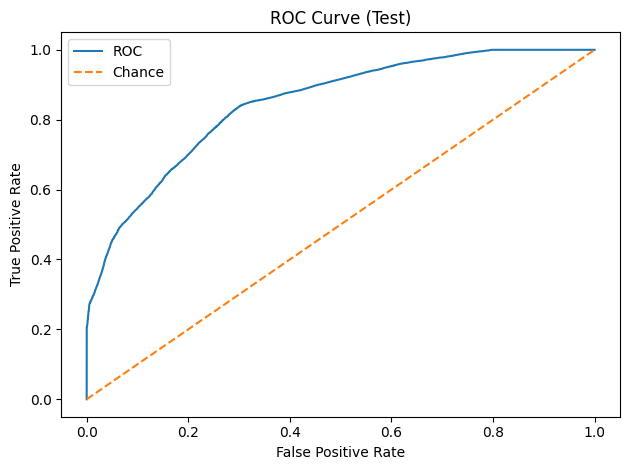

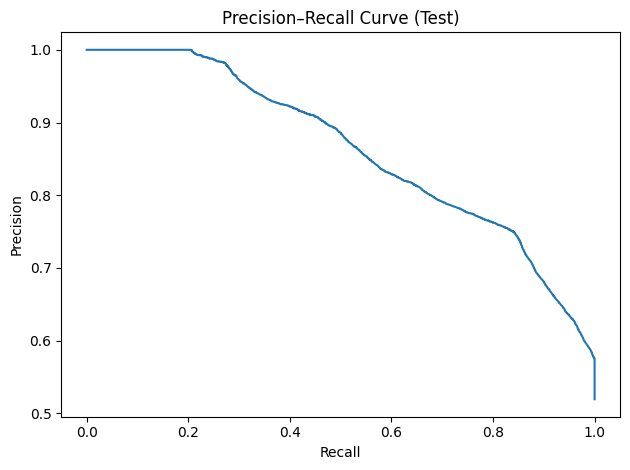

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fpr, tpr, _ = roc_curve(yclf_test, test_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(yclf_test, test_proba)
plt.figure()
plt.plot(rec, prec, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

out = pd.DataFrame({
    "y_true": yclf_test.astype(int),
    "proba":  test_proba,
    "pred_bestF1": yhat_best.astype(int),
    "pred_hiRecall": yhat_recall.astype(int)
})
out.to_csv("/mnt/data/rnn_symptom_prediction_results.csv", index=False)
print("Saved: /mnt/data/rnn_symptom_prediction_results.csv")

Saved: /mnt/data/rnn_symptom_prediction_results.csv


4.

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model

# Build a model that returns the tensor that feeds the classification output
# (i.e., the last shared representation before the risk_class Dense(1))
embed_model = Model(inputs=model.input, outputs=model.get_layer('risk_class').input)

# Choose which split to cluster on:
X_split = X_test  # or X_val / X_train

# Compute embeddings
Z = embed_model.predict(X_split, batch_size=256)   # shape: (N, D)
print("Embeddings shape:", Z.shape)

127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Embeddings shape: (32463, 64)


In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Ks = range(2, 9)
sil = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lbl = km.fit_predict(Z)
    sil.append(silhouette_score(Z, lbl))
best_k = Ks[int(np.argmax(sil))]
print("Silhouette per K:", dict(zip(Ks, np.round(sil, 3))))
print("Best K:", best_k)

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
clusters = kmeans.fit_predict(Z)  # (N,)

Silhouette per K: {2: np.float32(0.216), 3: np.float32(0.219), 4: np.float32(0.239), 5: np.float32(0.259), 6: np.float32(0.311), 7: np.float32(0.342), 8: np.float32(0.364)}
Best K: 8


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisati

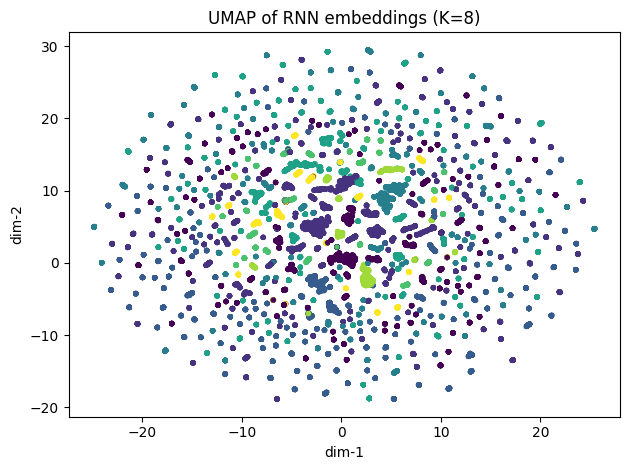

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

try:
    import umap
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.15, random_state=42)
    Y = reducer.fit_transform(Z)
    title = "UMAP of RNN embeddings"
except Exception:
    Y = PCA(n_components=2, random_state=42).fit_transform(Z)
    title = "PCA of RNN embeddings"

plt.figure()
plt.scatter(Y[:,0], Y[:,1], c=clusters, s=8)
plt.title(f"{title} (K={best_k})")
plt.xlabel("dim-1"); plt.ylabel("dim-2")
plt.tight_layout(); plt.show()

In [44]:
import pandas as pd

# Get model predictions for the same split
proba, reg = model.predict(X_split, batch_size=256)   # heads: [classification, regression]
proba = proba.ravel()
reg   = reg.ravel()

df_prof = pd.DataFrame({
    "cluster": clusters,
    "proba": proba,
    "severity": reg
})
cluster_summary = df_prof.groupby("cluster").agg(
    n=("proba","size"),
    proba_mean=("proba","mean"),
    proba_std=("proba","std"),
    severity_mean=("severity","mean"),
    severity_std=("severity","std")
).reset_index().sort_values("proba_mean", ascending=False)

print("Cluster risk profile (sorted by mean predicted probability):")
display(cluster_summary)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
Cluster risk profile (sorted by mean predicted probability):


,cluster,n,proba_mean,proba_std,severity_mean,severity_std
5,5,1660,9.951050e-01,0.069243,0.529444,0.151597
4,4,4060,8.779081e-01,0.099623,0.556631,0.134336
0,0,5148,6.453105e-01,0.238205,0.541652,0.140759
1,1,7728,6.355034e-01,0.169629,0.477966,0.145303
7,7,1553,5.665947e-01,0.342473,0.514799,0.148636
2,2,6175,3.063346e-01,0.114611,0.434712,0.134777
3,3,4480,2.099926e-01,0.152920,0.435423,0.134507
6,6,1659,9.502313e-07,0.000012,0.441462,0.131634


In [45]:
inv_vocab = {q: {v:k for k,v in vocab_maps[q].items()} for q in feature_steps}

# Recover chosen category id per person for each question/step from one-hot X
cat_ids = {q: np.argmax(X_split[:, i, :], axis=1) for i, q in enumerate(feature_steps)}
cat_vals = {q: np.array([inv_vocab[q].get(int(j), f"cat_{int(j)}") for j in ids])
            for q, ids in cat_ids.items()}

def top_categories_for_cluster(q, c, topn=5):
    m = (clusters == c)
    s = pd.Series(cat_vals[q][m])
    return s.value_counts().head(topn)

# Build a compact “signature” per cluster: top categories for each question
signatures = {}
for c in sorted(np.unique(clusters)):
    sig = {}
    for q in feature_steps:
        vc = top_categories_for_cluster(q, c, topn=3)
        sig[q] = ", ".join([f"{ix} ({cnt})" for ix, cnt in vc.items()])
    signatures[c] = sig

sig_df = pd.DataFrame(signatures).T  # rows=clusters, cols=questions
sig_df.index.name = "cluster"
print("Top categories (counts) per cluster and question:")
display(sig_df)

Top categories (counts) per cluster and question:


,Gender,Country,Occupation,self_employed,family_history,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,care_options
cluster,,,,,,,,,,,,,,
0,"Male (3664), Female (1484)","United States (2920), United Kingdom (1225), N...","Housewife (1164), Corporate (1107), Student (1...","No (4483), Yes (441), Unknown (224)","Yes (4263), No (885)","1-14 days (1092), More than 2 months (1057), 1...","Yes (1786), Maybe (1745), No (1617)","Yes (1943), Maybe (1670), No (1535)","No (1801), Maybe (1693), Yes (1654)","Low (1765), Medium (1712), High (1671)","No (2713), Yes (2435)","Maybe (1844), No (1762), Yes (1542)","Maybe (1772), Yes (1730), No (1646)",No (5148)
1,"Male (5846), Female (1882)","United States (5899), Canada (897), United Kin...","Housewife (1804), Corporate (1628), Student (1...","No (6790), Yes (848), Unknown (90)","No (5111), Yes (2617)","15-30 days (1600), 1-14 days (1554), More than...","Maybe (2765), Yes (2613), No (2350)","Yes (2927), Maybe (2449), No (2352)","No (2717), Maybe (2566), Yes (2445)","Low (2676), Medium (2660), High (2392)","No (4113), Yes (3615)","Maybe (2742), No (2693), Yes (2293)","Maybe (2638), Yes (2558), No (2532)","Yes (4340), Not sure (3226), No (162)"
2,"Male (5627), Female (548)","United States (3338), United Kingdom (1870), C...","Housewife (1462), Corporate (1364), Student (1...","No (5900), Yes (262), Unknown (13)","No (6169), Yes (6)","1-14 days (1327), 15-30 days (1260), More than...","Maybe (2165), Yes (2143), No (1867)","Yes (2414), No (1920), Maybe (1841)","No (2187), Maybe (2103), Yes (1885)","Low (2162), Medium (2144), High (1869)","No (3334), Yes (2841)","No (2174), Maybe (2143), Yes (1858)","Maybe (2096), No (2054), Yes (2025)",No (6175)
3,"Male (3500), Female (980)","United States (3242), United Kingdom (930), Au...","Housewife (1039), Corporate (946), Student (915)","No (4400), Yes (80)","No (4457), Yes (23)","15-30 days (914), 31-60 days (913), More than ...","Maybe (1586), Yes (1515), No (1379)","Yes (1714), Maybe (1402), No (1364)","No (1590), Maybe (1541), Yes (1349)","Low (1589), Medium (1542), High (1349)","No (2345), Yes (2135)","No (1570), Maybe (1558), Yes (1352)","Maybe (1523), No (1479), Yes (1478)","Not sure (4443), Yes (37)"
4,"Male (2916), Female (1144)","United States (3601), Canada (249), United Kin...","Housewife (959), Corporate (854), Student (784)","No (3760), Yes (270), Unknown (30)","Yes (4030), No (30)","15-30 days (842), 1-14 days (817), 31-60 days ...","Maybe (1382), Yes (1366), No (1312)","Yes (1542), Maybe (1307), No (1211)","No (1451), Maybe (1348), Yes (1261)","Medium (1443), Low (1409), High (1208)","No (2130), Yes (1930)","Maybe (1426), No (1414), Yes (1220)","Maybe (1389), No (1349), Yes (1322)",Yes (4060)
5,"Female (1125), Male (535)","Canada (435), Australia (313), United States (...","Others (360), Student (353), Housewife (326)","No (1035), Yes (445), Unknown (180)","Yes (1161), No (499)","More than 2 months (343), 1-14 days (338), Go ...","Yes (630), No (526), Maybe (504)","Yes (605), No (533), Maybe (522)","Maybe (606), Yes (529), No (525)","High (563), Medium (557), Low (540)","No (836), Yes (824)","No (601), Maybe (553), Yes (506)","Maybe (583), No (565), Yes (512)","Yes (1290), Not sure (354), No (16)"
6,"Male (1594), Female (65)","France (253), Israel (167), Italy (153)","Housewife (408), Corporate (406), Student (294)","No (1560), Yes (81), Unknown (18)","No (1549), Yes (110)","1-14 days (373), 15-30 days (338), Go out Ever...","Maybe (598), Yes (547), No (514)","Yes (616), Maybe (540), No (503)","No (580), Maybe (558), Yes (521)","Medium (589), Low (569), High (501)","No (899), Yes (760)","Maybe (608), No (562), Yes (489)","Maybe (617), Yes (525), No (517)","No (905), Not sure (486), Yes (268)"
7,"Male (878), Female (675)","United Kingdom (845), Ireland (170), Germany (...","Housewife (377), Corporate (319), Student (303)","No (802), Yes (749), Unknown (2)","Yes (977), 

In [46]:
from scipy.stats import chi2_contingency

chi_rows = []
for q in feature_steps:
    # contingency: rows=clusters, cols=categories for q
    cats = pd.Categorical(cat_vals[q], categories=sorted(set(cat_vals[q])))
    df_ct = pd.crosstab(pd.Series(clusters, name="cluster"), pd.Series(cats, name=q))
    chi2, p, dof, _ = chi2_contingency(df_ct)
    chi_rows.append({"question": q, "chi2": chi2, "p_value": p})

chi_df = pd.DataFrame(chi_rows).sort_values("chi2", ascending=False)
print("Questions that most differentiate clusters (higher χ² = bigger differences):")
display(chi_df.head(10))

Questions that most differentiate clusters (higher χ² = bigger differences):


,question,chi2,p_value
1,Country,46058.535864,0.000000
13,care_options,43714.723144,0.000000
4,family_history,18630.903411,0.000000
3,self_employed,5124.922173,0.000000
0,Gender,3289.530661,0.000000
2,Occupation,54.191644,0.002124
6,Growing_Stress,31.192865,0.005209
5,Days_Indoors,25.121690,0.621204
9,Mood_Swings,21.769369,0.083479
8,Mental_Health_History,21.609742,0.086997


In [47]:
cluster_summary.to_csv("/mnt/data/cluster_risk_profile.csv", index=False)
sig_df.to_csv("/mnt/data/cluster_top_categories.csv")
pd.DataFrame({"K": list(Ks), "silhouette": sil}).to_csv("/mnt/data/cluster_silhouette_scan.csv", index=False)
print("Saved: cluster_risk_profile.csv, cluster_top_categories.csv, cluster_silhouette_scan.csv in /mnt/data/")

Saved: cluster_risk_profile.csv, cluster_top_categories.csv, cluster_silhouette_scan.csv in /mnt/data/



### Tips & Variations
- **Class imbalance**: try `class_weight` in `model.fit` or **focal loss** for `risk_class`.
- **Attention**: swap GRU with an attention layer over steps to highlight influential questions.
- **Alternative sequence**: group questions by theme (demographics → history → symptoms → care) and experiment with step orders.
- **Real time series**: if you add repeated surveys, stack them in chronological order per person and feed real sequences instead of question steps.
